In [1]:
import os
import random as rn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense

np.set_printoptions(linewidth=200)

%matplotlib inline

In [2]:
def set_random_seeds():
    RANDOM_SEED = 1234
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

In [3]:
url = "https://docs.google.com/spreadsheets/d/1SsPmWxs3bmMOENpZ4VQvCd2Lo2DrqvvgKnLhHiQJ31c/edit#gid=889125878"
export_url = url.replace('/edit#gid=', '/export?format=csv&gid=')

df = pd.read_csv(export_url, skiprows=5, decimal=",")
df.head()

,Seq,Season,Year,Title,Location,Continent,Original air date,Scheduled Duration,Female,Female Age,...,F_Military,F_Weight Loss,Male,Male Age,Start MPSR,End MPSR,M. Duration,M_Military,M_Weight Loss,M_Build
0,1.0,1.0,2013.0,The Jungle Curse,Costa Rica,North America,23-jun.-13,21.0,Kim Shelton,22.0,...,NaN,NaN,Shane Lewis,40.0,7.6,8.4,21.0,NaN,NaN,NaN
1,2.0,1.0,2013.0,Terror in Tanzania,Tanzania,Africa,30-jun.-13,21.0,Kellie Nightlinger,38.0,...,NaN,NaN,EJ Snyder,46.0,7.3,8.2,21.0,NaN,NaN,NaN
2,3.0,1.0,2013.0,Island From Hell,Maldives,Asia,7-jul.-13,21.0,Alison Teal,29.0,...,NaN,NaN,Jonathan Klay,36.0,6.9,7.2,21.0,NaN,NaN,NaN
3,4.0,1.0,2013.0,Punishment in Panama,Panama,North America,14-jul.-13,21.0,Laura Zerra,27.0,...,NaN,NaN,Clint Jivoin,24.0,6.9,7.3,21.0,NaN,NaN,NaN
4,5.0,1.0,2013.0,Breaking Borneo,Borneo,Asia,21-jul.-13,21.0,Julie Wright,30.0,...,NaN,NaN,Puma Cabra,38.0,7.1,6.1,9.0,NaN,NaN,NaN


In [4]:
shared_cols = [
    "Scheduled Duration",
    "Location",
    "Continent",
]

female_cols = [
    "Female Age",
    "Start FPSR",
    "End FPSR",
    "F. Duration",
]

male_cols = [
    "Male Age",
    "Start MPSR",
    "End MPSR",
    "M. Duration",
]

final_cols = shared_cols + ["Age", "Start PSR", "End PSR", "Duration"]

In [5]:
df_female = df[shared_cols + female_cols]
df_female.columns = final_cols

print(df_female.shape)
df_female.head()

(82, 7)


,Scheduled Duration,Location,Continent,Age,Start PSR,End PSR,Duration
0,21.0,Costa Rica,North America,22.0,5.8,7.8,21.0
1,21.0,Tanzania,Africa,38.0,7.5,8.1,21.0
2,21.0,Maldives,Asia,29.0,8.0,8.4,21.0
3,21.0,Panama,North America,27.0,7.9,7.2,21.0
4,21.0,Borneo,Asia,30.0,5.5,5.0,18.0


In [6]:
df_male = df[shared_cols + male_cols]
df_male.columns = final_cols

print(df_male.shape)
df_male.head()

(82, 7)


,Scheduled Duration,Location,Continent,Age,Start PSR,End PSR,Duration
0,21.0,Costa Rica,North America,40.0,7.6,8.4,21.0
1,21.0,Tanzania,Africa,46.0,7.3,8.2,21.0
2,21.0,Maldives,Asia,36.0,6.9,7.2,21.0
3,21.0,Panama,North America,24.0,6.9,7.3,21.0
4,21.0,Borneo,Asia,38.0,7.1,6.1,9.0


In [7]:
df_final = pd.concat((df_female, df_male), ignore_index=True)

df_final["sex"] = [1] * df_female.shape[0] + [0] * df_male.shape[0]
df_final["has_finished"] = df_final["Scheduled Duration"] == df_final.Duration
df_final.dropna(how="any", subset=final_cols, inplace=True)

print(df_final.shape)
df_final.sample(n=10, random_state=1234).head(10)

(132, 9)


,Scheduled Duration,Location,Continent,Age,Start PSR,End PSR,Duration,sex,has_finished
6,21.0,Panama,North America,45.0,7.8,8.0,21.0,1,True
52,23.0,Namibia,Africa,31.0,7.8,7.4,9.0,1,False
36,21.0,Panama,North America,23.0,6.2,7.0,21.0,1,True
62,21.0,Louisiana,North America,30.0,7.2,7.6,21.0,1,True
69,21.0,Croatia,Europe,29.0,6.8,6.7,18.0,1,False
98,21.0,Andros Islands,North America,29.0,7.6,7.8,21.0,0,True
130,21.0,Florida,North America,28.0,7.4,4.1,5.0,0,False
29,21.0,Himalayas,Asia,31.0,6.4,6.9,21.0,1,True
55,19.0,Ecuador,South America,31.0,6.2,6.2,19.0,1,True
67,21.0,Belize,North America,35.0,6.9,7.4,21.0,1,True


In [8]:
loc_enc = LabelEncoder()
loc_enc.fit(df_final.Location.values)

cont_enc = LabelEncoder()
cont_enc.fit(df_final.Continent.values)

df_samples = df_final.copy(deep=True)
df_samples.Location = loc_enc.transform(df_samples.Location)
df_samples.Continent = cont_enc.transform(df_samples.Continent)

df_samples.sample(n=10, random_state=1234).head(10)

,Scheduled Duration,Location,Continent,Age,Start PSR,End PSR,Duration,sex,has_finished
6,21.0,30,4,45.0,7.8,8.0,21.0,1,True
52,23.0,28,0,31.0,7.8,7.4,9.0,1,False
36,21.0,30,4,23.0,6.2,7.0,21.0,1,True
62,21.0,22,4,30.0,7.2,7.6,21.0,1,True
69,21.0,14,3,29.0,6.8,6.7,18.0,1,False
98,21.0,2,4,29.0,7.6,7.8,21.0,0,True
130,21.0,18,4,28.0,7.4,4.1,5.0,0,False
29,21.0,20,1,31.0,6.4,6.9,21.0,1,True
55,19.0,16,6,31.0,6.2,6.2,19.0,1,True
67,21.0,5,4,35.0,6.9,7.4,21.0,1,True


<Axes: xlabel='sex'>

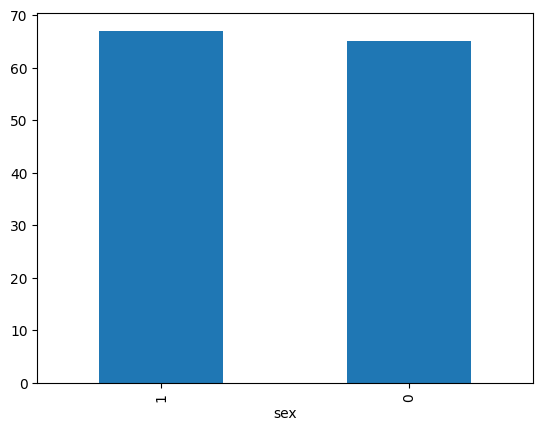

In [9]:
df_samples.sex.value_counts().plot(kind="bar")

<Axes: xlabel='has_finished'>

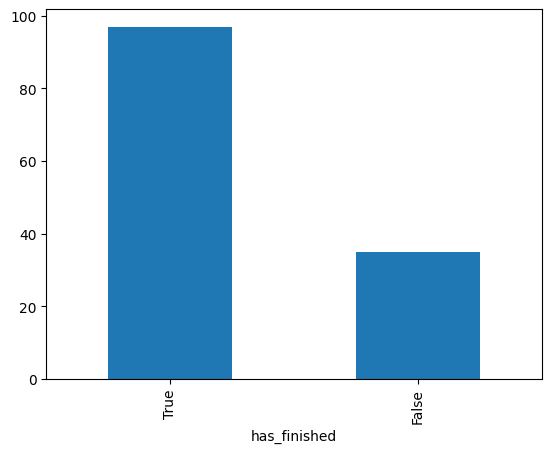

In [10]:
df_samples.has_finished.value_counts().plot(kind="bar")

# Treinando o Modelo

In [11]:
y_sex = df_samples.sex.values
y_has_finished = df_samples.has_finished.values

x = df_samples[final_cols + ["sex"]].values

std = StandardScaler()
std.fit(x)
x = std.transform(x)

print(x.shape, x.dtype)

(132, 8) float64


In [12]:
set_random_seeds()

model = Sequential([
    Dense(4, activation="relu", input_dim=8, name="enc_1"),
    Dense(2, activation="relu", name="embeddings"),
    Dense(4, activation="relu", name="dec_1"),
    Dense(8, activation="linear", name="decoded")
])
model.summary()

model.compile(optimizer="adam", loss="mean_squared_error")

model.fit(x, x, batch_size=16, epochs=500, verbose=1)

Metal device set to: Apple M1


2023-07-06 10:01:38.132751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-06 10:01:38.133047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_1 (Dense)               (None, 4)                 36        
                                                                 
 embeddings (Dense)          (None, 2)                 10        
                                                                 
 dec_1 (Dense)               (None, 4)                 12        
                                                                 
 decoded (Dense)             (None, 8)                 40        
                                                                 
Total params: 98
Trainable params: 98
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2023-07-06 10:01:38.865983: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-06 10:01:39.191262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 3s 38ms/step - loss: 1.0347
Epoch 2/500
9/9 [==============================] - 0s 9ms/step - loss: 1.0257
Epoch 3/500
9/9 [==============================] - 0s 6ms/step - loss: 1.0195
Epoch 4/500
9/9 [==============================] - 0s 6ms/step - loss: 1.0133
Epoch 5/500
9/9 [==============================] - 0s 8ms/step - loss: 1.0098
Epoch 6/500
9/9 [==============================] - 0s 16ms/step - loss: 1.0056
Epoch 7/500
9/9 [==============================] - 0s 13ms/step - loss: 1.0024
Epoch 8/500
9/9 [==============================] - 0s 8ms/step - loss: 0.9995
Epoch 9/500
9/9 [==============================] - 0s 6ms/step - loss: 0.9969
Epoch 10/500
9/9 [==============================] - 0s 6ms/step - loss: 0.9946
Epoch 11/500
9/9 [==============================] - 0s 6ms/step - loss: 0.9926
Epoch 12/500
9/9 [==============================] - 0s 7ms/step - loss: 0.9907
Epoch 13/500
9/9 [==============================] - 0s 6ms/step - loss

9/9 [==============================] - 0s 6ms/step - loss: 0.7342
Epoch 105/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7321
Epoch 106/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7303
Epoch 107/500
9/9 [==============================] - 0s 12ms/step - loss: 0.7279
Epoch 108/500
9/9 [==============================] - 0s 7ms/step - loss: 0.7253
Epoch 109/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7231
Epoch 110/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7210
Epoch 111/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7186
Epoch 112/500
9/9 [==============================] - 0s 5ms/step - loss: 0.7170
Epoch 113/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7142
Epoch 114/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7116
Epoch 115/500
9/9 [==============================] - 0s 6ms/step - loss: 0.7096
Epoch 116/500
9/9 [==============================] - 

9/9 [==============================] - 0s 6ms/step - loss: 0.5947
Epoch 207/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5941
Epoch 208/500
9/9 [==============================] - 0s 5ms/step - loss: 0.5934
Epoch 209/500
9/9 [==============================] - 0s 5ms/step - loss: 0.5931
Epoch 210/500
9/9 [==============================] - 0s 7ms/step - loss: 0.5927
Epoch 211/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5919
Epoch 212/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5916
Epoch 213/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5908
Epoch 214/500
9/9 [==============================] - 0s 5ms/step - loss: 0.5903
Epoch 215/500
9/9 [==============================] - 0s 5ms/step - loss: 0.5896
Epoch 216/500
9/9 [==============================] - 0s 7ms/step - loss: 0.5887
Epoch 217/500
9/9 [==============================] - 0s 8ms/step - loss: 0.5886
Epoch 218/500
9/9 [==============================] - 0

9/9 [==============================] - 0s 6ms/step - loss: 0.5613
Epoch 309/500
9/9 [==============================] - 0s 15ms/step - loss: 0.5611
Epoch 310/500
9/9 [==============================] - 0s 9ms/step - loss: 0.5605
Epoch 311/500
9/9 [==============================] - 0s 13ms/step - loss: 0.5598
Epoch 312/500
9/9 [==============================] - 0s 8ms/step - loss: 0.5594
Epoch 313/500
9/9 [==============================] - 0s 13ms/step - loss: 0.5593
Epoch 314/500
9/9 [==============================] - 0s 9ms/step - loss: 0.5588
Epoch 315/500
9/9 [==============================] - 0s 9ms/step - loss: 0.5584
Epoch 316/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5579
Epoch 317/500
9/9 [==============================] - 0s 8ms/step - loss: 0.5578
Epoch 318/500
9/9 [==============================] - 0s 10ms/step - loss: 0.5576
Epoch 319/500
9/9 [==============================] - 0s 7ms/step - loss: 0.5573
Epoch 320/500
9/9 [==============================]

9/9 [==============================] - 0s 6ms/step - loss: 0.5364
Epoch 411/500
9/9 [==============================] - 0s 9ms/step - loss: 0.5369
Epoch 412/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5355
Epoch 413/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5353
Epoch 414/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5350
Epoch 415/500
9/9 [==============================] - 0s 7ms/step - loss: 0.5349
Epoch 416/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5345
Epoch 417/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5347
Epoch 418/500
9/9 [==============================] - 0s 5ms/step - loss: 0.5348
Epoch 419/500
9/9 [==============================] - 0s 21ms/step - loss: 0.5340
Epoch 420/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5337
Epoch 421/500
9/9 [==============================] - 0s 6ms/step - loss: 0.5336
Epoch 422/500
9/9 [==============================] - 

In [13]:
model_enc = Model(inputs=model.inputs, outputs=model.get_layer("embeddings").output)
model_enc.summary()

y_embed = model_enc.predict(x)
y_embed.shape

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_1_input (InputLayer)    [(None, 8)]               0         
                                                                 
 enc_1 (Dense)               (None, 4)                 36        
                                                                 
 embeddings (Dense)          (None, 2)                 10        
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 20ms/step


2023-07-06 10:02:15.017446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(132, 2)

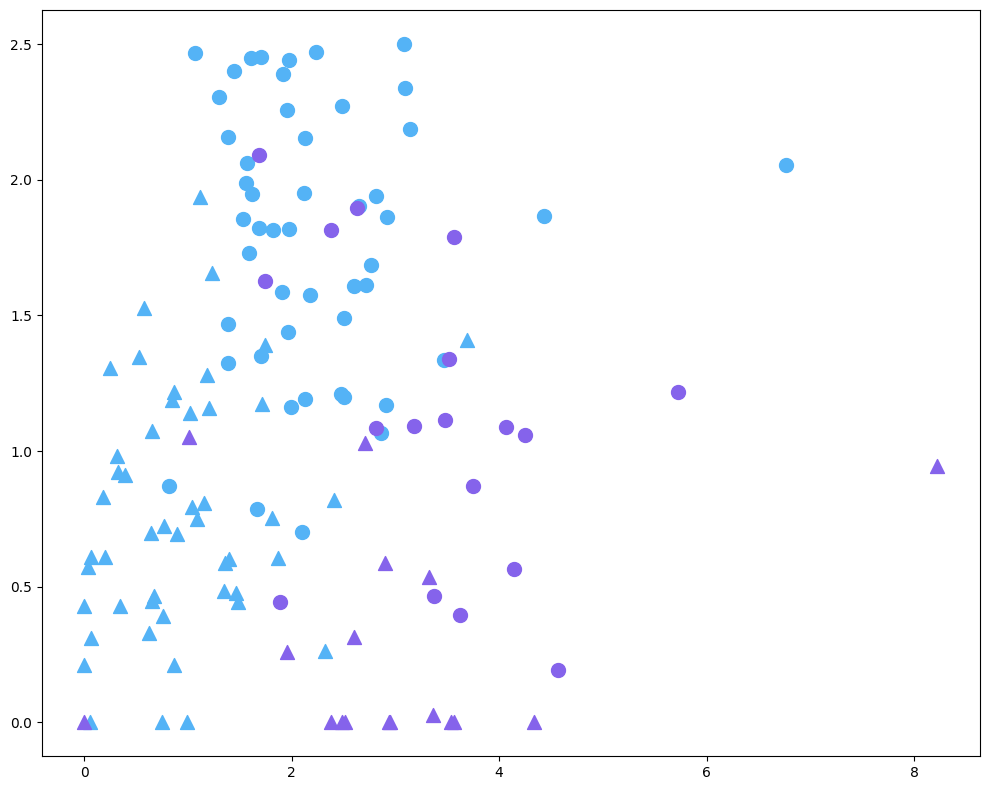

In [14]:
mask_women_has_finished = np.logical_and(y_sex == 1, y_has_finished)
mask_women_not_finished = np.logical_and(y_sex == 1, y_has_finished == False)
mask_men_has_finished = np.logical_and(y_sex == 0, y_has_finished)
mask_men_not_finished = np.logical_and(y_sex == 0, y_has_finished == False)

emb_whf = y_embed[mask_women_has_finished]
emb_wnf = y_embed[mask_women_not_finished]
emb_mhf = y_embed[mask_men_has_finished]
emb_mnf = y_embed[mask_men_not_finished]

plt.figure(figsize=(10, 8))
plt.scatter(emb_whf[:, 0], emb_whf[:, 1], marker="o", c="#54b3f6", s=100, label="women - has finished")
plt.scatter(emb_wnf[:, 0], emb_wnf[:, 1], marker="o", c="#8563eb", s=100, label="women - not finished")
plt.scatter(emb_mhf[:, 0], emb_mhf[:, 1], marker="^", c="#54b3f6", s=100, label="men - has finished")
plt.scatter(emb_mnf[:, 0], emb_mnf[:, 1], marker="^", c="#8563eb", s=100, label="men - not finished")

# plt.legend()
plt.tight_layout()

In [15]:
df_final.head()

,Scheduled Duration,Location,Continent,Age,Start PSR,End PSR,Duration,sex,has_finished
0,21.0,Costa Rica,North America,22.0,5.8,7.8,21.0,1,True
1,21.0,Tanzania,Africa,38.0,7.5,8.1,21.0,1,True
2,21.0,Maldives,Asia,29.0,8.0,8.4,21.0,1,True
3,21.0,Panama,North America,27.0,7.9,7.2,21.0,1,True
4,21.0,Borneo,Asia,30.0,5.5,5.0,18.0,1,False


In [16]:
df_me = pd.DataFrame([[21, "Brazil", "South America", 29, 1.0, 1.0, 1, 0]], columns=df_final.columns[:-1])
df_me

,Scheduled Duration,Location,Continent,Age,Start PSR,End PSR,Duration,sex
0,21,Brazil,South America,29,1.0,1.0,1,0


In [17]:
df_sample_me = df_me.copy(deep=True)
df_sample_me.Location = loc_enc.transform(df_sample_me.Location)
df_sample_me.Continent = cont_enc.transform(df_sample_me.Continent)

df_sample_me

,Scheduled Duration,Location,Continent,Age,Start PSR,End PSR,Duration,sex
0,21,9,6,29,1.0,1.0,1,0


In [18]:
x_me = std.transform(df_sample_me.values)

emb_me = model_enc.predict(x_me)
emb_me.shape

1/1 [==============================] - 0s 223ms/step


(1, 2)

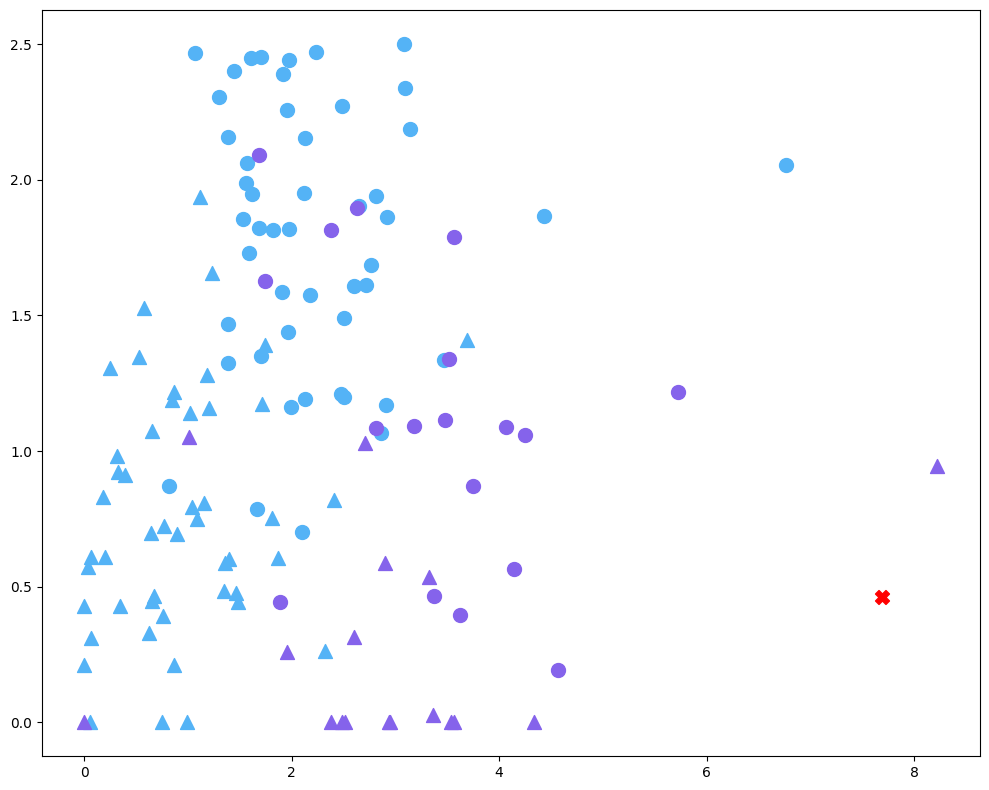

In [19]:
mask_women_has_finished = np.logical_and(y_sex == 1, y_has_finished)
mask_women_not_finished = np.logical_and(y_sex == 1, y_has_finished == False)
mask_men_has_finished = np.logical_and(y_sex == 0, y_has_finished)
mask_men_not_finished = np.logical_and(y_sex == 0, y_has_finished == False)

emb_whf = y_embed[mask_women_has_finished]
emb_wnf = y_embed[mask_women_not_finished]
emb_mhf = y_embed[mask_men_has_finished]
emb_mnf = y_embed[mask_men_not_finished]

plt.figure(figsize=(10, 8))
plt.scatter(emb_whf[:, 0], emb_whf[:, 1], marker="o", c="#54b3f6", s=100, label="women - has finished")
plt.scatter(emb_wnf[:, 0], emb_wnf[:, 1], marker="o", c="#8563eb", s=100, label="women - not finished")
plt.scatter(emb_mhf[:, 0], emb_mhf[:, 1], marker="^", c="#54b3f6", s=100, label="men - has finished")
plt.scatter(emb_mnf[:, 0], emb_mnf[:, 1], marker="^", c="#8563eb", s=100, label="men - not finished")
plt.scatter(emb_me[:, 0], emb_me[:, 1], marker="X", c="red", s=100, label="me")

# plt.legend()
plt.tight_layout()
plt.savefig("../plots/me.png", dpi=300)